In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, exposure
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, resnet34
import time


In [4]:
# Blob Detection Methods (LoG, DoG, HoG)
def log_blob_detection(image):
    log_image = filters.laplace(image)
    return log_image

def dog_blob_detection(image):
    gaussian1 = cv2.GaussianBlur(image, (5,5), 1.0)
    gaussian2 = cv2.GaussianBlur(image, (5,5), 2.0)
    dog_image = gaussian1 - gaussian2
    return dog_image

def hog_blob_detection(image):
    from skimage.feature import hog
    _, hog_image = hog(image, visualize=True)
    return hog_image

# Image Quality Enhancement
def enhance_image(image):
    bright_image = cv2.convertScaleAbs(image, alpha=1.2, beta=30)
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(bright_image, -1, sharpen_kernel)
    noise_removed = cv2.GaussianBlur(sharpened, (3,3), 0)
    equalized = cv2.equalizeHist(noise_removed)
    return equalized


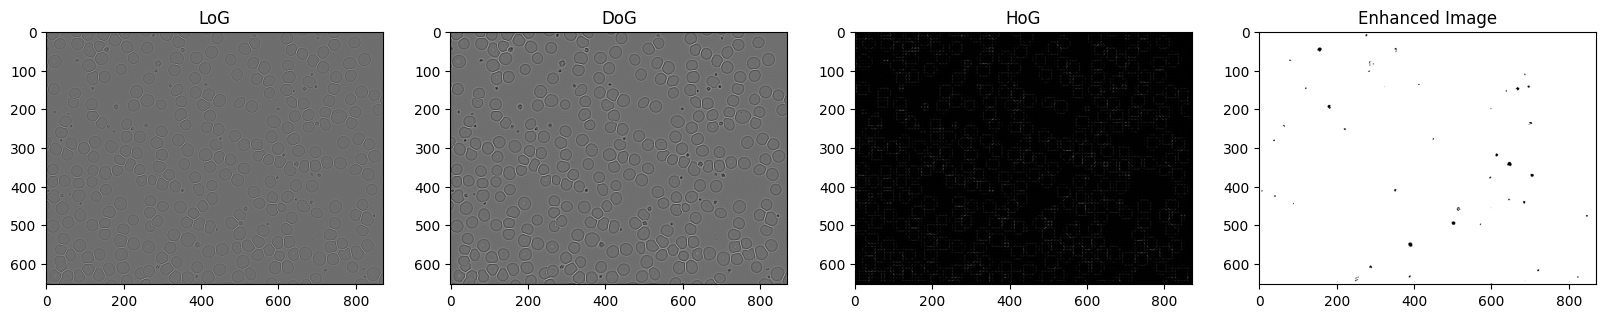

In [5]:
# Load an example image (replace with microscope/satellite image)
image = io.imread('Microscope_Picture.jpg', as_gray=True)
log_result = log_blob_detection(image)
dog_result = dog_blob_detection(image)
hog_result = hog_blob_detection(image)
enhanced_image = enhance_image(image)

# Display results
fig, axes = plt.subplots(1, 4, figsize=(20,5))
axes[0].imshow(log_result, cmap='gray'); axes[0].set_title('LoG')
axes[1].imshow(dog_result, cmap='gray'); axes[1].set_title('DoG')
axes[2].imshow(hog_result, cmap='gray'); axes[2].set_title('HoG')
axes[3].imshow(enhanced_image, cmap='gray'); axes[3].set_title('Enhanced Image')
plt.show()

In [6]:
# CIFAR-100 Classification using ResNet
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

def train_model(model, trainloader, testloader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    start_time = time.time()

    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

    print(f"Training Time: {time.time() - start_time} seconds")
    return model

resnet18_model = resnet18(pretrained=True)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 100)
trained_resnet18 = train_model(resnet18_model, trainloader, testloader)

resnet34_model = resnet34(pretrained=True)
resnet34_model.fc = nn.Linear(resnet34_model.fc.in_features, 100)
trained_resnet34 = train_model(resnet34_model, trainloader, testloader)

def evaluate_model(model, testloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

evaluate_model(trained_resnet18, testloader)
evaluate_model(trained_resnet34, testloader)

100%|██████████| 169M/169M [00:15<00:00, 10.9MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


Epoch 1, Loss: 2.704831172438229
Epoch 2, Loss: 1.9147828911881313
Epoch 3, Loss: 1.5639832525911843
Epoch 4, Loss: 1.3022790657894692
Epoch 5, Loss: 1.0826002368536751
Epoch 6, Loss: 0.8991561788122368
Epoch 7, Loss: 0.7435674686413591
Epoch 8, Loss: 0.6224518270443773
Epoch 9, Loss: 0.5310147163813072
Epoch 10, Loss: 0.442470702178338
Training Time: 161.80769991874695 seconds


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 194MB/s]


Epoch 1, Loss: 2.8250291359698987
Epoch 2, Loss: 2.1702734338657934
Epoch 3, Loss: 1.6874165022769547
Epoch 4, Loss: 1.6856119242470589
Epoch 5, Loss: 1.4547729745240467
Epoch 6, Loss: 1.33134059939543
Epoch 7, Loss: 1.2203431015124406
Epoch 8, Loss: 0.8745408430123878
Epoch 9, Loss: 1.2792495125547394
Epoch 10, Loss: 0.8849002011596699
Training Time: 193.3195765018463 seconds
Accuracy: 53.12%
Accuracy: 52.73%


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Set device and random seed for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# MNIST dataset transformation and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define a simple CNN to extract embeddings from images
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 32, 5),  # (28-5+1)=24
            nn.ReLU(),
            nn.MaxPool2d(2),      # 24/2=12
            nn.Conv2d(32, 64, 5), # (12-5+1)=8
            nn.ReLU(),
            nn.MaxPool2d(2)       # 8/2=4
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 256),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.convnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Compute class prototypes (mean embedding per class)
def compute_prototypes(embeddings, targets, num_classes):
    prototypes = []
    for cls in range(num_classes):
        cls_indices = (targets == cls).nonzero().squeeze()
        cls_embeddings = embeddings[cls_indices]
        prototype = cls_embeddings.mean(0)
        prototypes.append(prototype)
    return torch.stack(prototypes)

# Episodic training for few-shot learning using a prototypical network
def episodic_training(embedding_net, optimizer, num_episodes=100, num_classes=5, k_shot=5, q_query=10):
    embedding_net.train()
    loss_fn = nn.CrossEntropyLoss()
    for episode in range(num_episodes):
        # Randomly select 'num_classes' classes for this episode
        classes = np.random.choice(np.unique(mnist_train.targets.numpy()), num_classes, replace=False)
        support_images, support_labels = [], []
        query_images, query_labels = [], []

        # For each class, select k_shot support examples and q_query query examples
        for idx, cls in enumerate(classes):
            cls_indices = np.where(mnist_train.targets.numpy() == cls)[0]
            selected = np.random.choice(cls_indices, k_shot + q_query, replace=False)
            support_idx = selected[:k_shot]
            query_idx = selected[k_shot:]
            for i in support_idx:
                img, _ = mnist_train[i]
                support_images.append(img)
                support_labels.append(idx)
            for i in query_idx:
                img, _ = mnist_train[i]
                query_images.append(img)
                query_labels.append(idx)

        support_images = torch.stack(support_images).to(device)
        support_labels = torch.tensor(support_labels).to(device)
        query_images = torch.stack(query_images).to(device)
        query_labels = torch.tensor(query_labels).to(device)

        optimizer.zero_grad()
        support_embeddings = embedding_net(support_images)
        query_embeddings = embedding_net(query_images)
        prototypes = compute_prototypes(support_embeddings, support_labels, num_classes)

        # Calculate Euclidean distances between query embeddings and prototypes
        dists = torch.cdist(query_embeddings, prototypes)
        logits = -dists  # lower distance means higher similarity
        loss = loss_fn(logits, query_labels)
        loss.backward()
        optimizer.step()

        if (episode+1) % 10 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Loss: {loss.item():.4f} 😊")

# Initialize model and optimizer
embedding_net = EmbeddingNet().to(device)
optimizer = optim.Adam(embedding_net.parameters(), lr=0.001)

print("Starting Episodic Training for Prototypical Network 😊")
episodic_training(embedding_net, optimizer)


Starting Episodic Training for Prototypical Network 😊
Episode 10/100, Loss: 0.6438 😊
Episode 20/100, Loss: 0.4389 😊
Episode 30/100, Loss: 0.1222 😊
Episode 40/100, Loss: 0.3496 😊
Episode 50/100, Loss: 0.1259 😊
Episode 60/100, Loss: 0.1050 😊
Episode 70/100, Loss: 0.1030 😊
Episode 80/100, Loss: 0.3417 😊
Episode 90/100, Loss: 0.0848 😊
Episode 100/100, Loss: 0.0612 😊


100%|██████████| 169M/169M [00:05<00:00, 30.9MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weig

Training ResNet18 😊
Epoch [1/10] ResNet18 - Train Loss: 2.9917, Test Loss: 2.3752, Accuracy: 37.79% 😊
Epoch [2/10] ResNet18 - Train Loss: 2.2679, Test Loss: 2.1230, Accuracy: 43.67% 😊
Epoch [3/10] ResNet18 - Train Loss: 2.0147, Test Loss: 2.0169, Accuracy: 46.24% 😊
Epoch [4/10] ResNet18 - Train Loss: 1.8560, Test Loss: 1.8182, Accuracy: 50.71% 😊
Epoch [5/10] ResNet18 - Train Loss: 1.7428, Test Loss: 1.8768, Accuracy: 50.19% 😊
Epoch [6/10] ResNet18 - Train Loss: 1.6508, Test Loss: 1.7624, Accuracy: 52.75% 😊
Epoch [7/10] ResNet18 - Train Loss: 1.5589, Test Loss: 1.7505, Accuracy: 52.85% 😊
Epoch [8/10] ResNet18 - Train Loss: 1.4886, Test Loss: 1.7409, Accuracy: 53.25% 😊
Epoch [9/10] ResNet18 - Train Loss: 1.4216, Test Loss: 1.7013, Accuracy: 54.63% 😊
Epoch [10/10] ResNet18 - Train Loss: 1.3634, Test Loss: 1.6292, Accuracy: 55.62% 😊
Training ResNet34 😊
Epoch [1/10] ResNet34 - Train Loss: 3.1714, Test Loss: 3.0329, Accuracy: 30.08% 😊
Epoch [2/10] ResNet34 - Train Loss: 2.4526, Test Loss: 2.

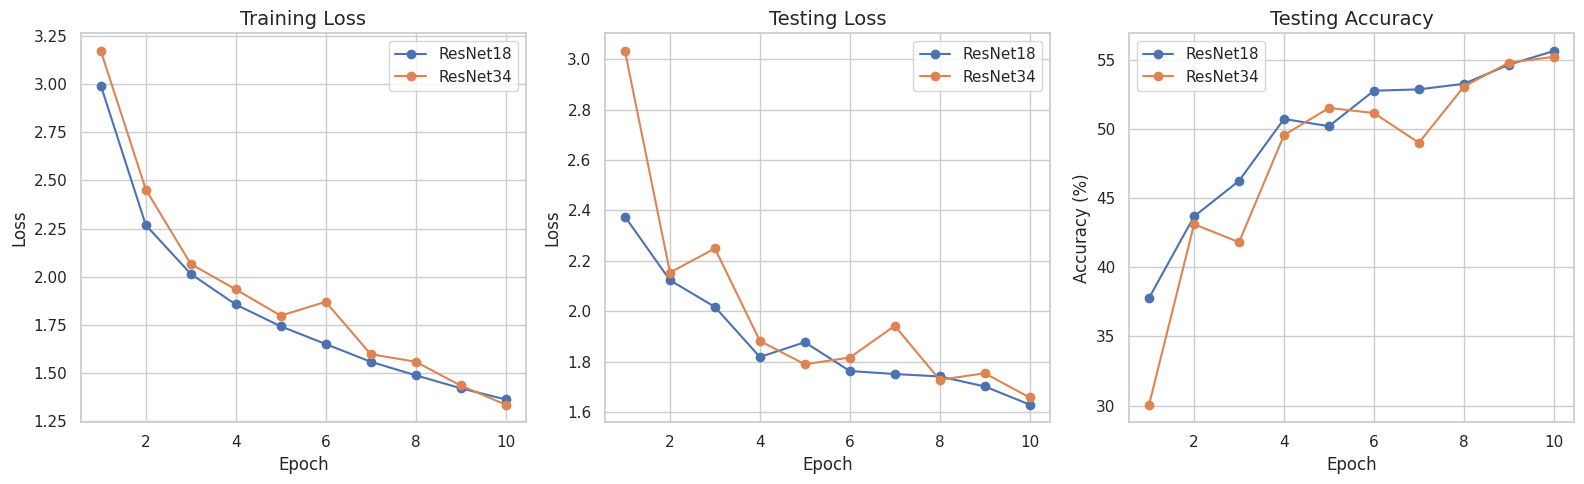


Final Evaluation Metrics:
      Model  Final Accuracy (%)
0  ResNet18               55.62
1  ResNet34               55.20


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style for better visuals
sns.set(style="whitegrid")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.001
num_classes = 100

# Data augmentation and normalization for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

# Load CIFAR-100 datasets
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Function to load and modify the pre-trained ResNet model
def get_model(model_name):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=True)
    else:
        raise ValueError("Model not supported!")
    # Replace the final fully connected layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# Training function that saves metrics
def train_model(model, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)

# Evaluation function that saves metrics
def evaluate_model(model, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return test_loss / len(test_loader), accuracy

# Initialize models and prepare to store metrics
models_to_train = {
    'ResNet18': get_model('resnet18'),
    'ResNet34': get_model('resnet34')
}

results = {}
history = {}  # To store training and testing metrics for each model

for model_name, model in models_to_train.items():
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    history[model_name] = {'train_loss': [], 'test_loss': [], 'accuracy': []}
    print(f"Training {model_name} 😊")
    for epoch in range(num_epochs):
        train_loss = train_model(model, optimizer, criterion)
        test_loss, accuracy = evaluate_model(model, criterion)
        history[model_name]['train_loss'].append(train_loss)
        history[model_name]['test_loss'].append(test_loss)
        history[model_name]['accuracy'].append(accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}] {model_name} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}% 😊")
    results[model_name] = accuracy

# Visualization: Plotting the training curves and accuracy for each model
epochs = range(1, num_epochs+1)
plt.figure(figsize=(16, 5))

# Plot training loss
plt.subplot(1, 3, 1)
for model_name in history:
    plt.plot(epochs, history[model_name]['train_loss'], marker='o', label=model_name)
plt.title('Training Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Plot test loss
plt.subplot(1, 3, 2)
for model_name in history:
    plt.plot(epochs, history[model_name]['test_loss'], marker='o', label=model_name)
plt.title('Testing Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 3, 3)
for model_name in history:
    plt.plot(epochs, history[model_name]['accuracy'], marker='o', label=model_name)
plt.title('Testing Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Optionally, print final results in a tabular format
import pandas as pd
df_results = pd.DataFrame({
    'Model': list(results.keys()),
    'Final Accuracy (%)': list(results.values())
})
print("\nFinal Evaluation Metrics:")
print(df_results)
